# Model Testing
This notebook is used to test a variety of parameters for modeling, using one "chunk" of data (5000 phrases, approx 47000 words, about 2.5% of total dataset). Overfitting was a very common problem, and even strong regularization often didn't correct it. Lambda value of 0.1 had best results, but it's still overfitting.

### Factors found to have best results:
* activation = tanh
* optimizer = sgd
* one large hidden layer
* little to no dropout
* L2 regularization

Somethings to test:
LSTM layer vs GRU layer

In [5]:
from datetime import datetime
import pandas as pd
import numpy as np
from tensorflow import keras

start=datetime.now()
temp = pd.read_csv('Data/cv-valid-train.csv')
texts = temp['text']

words_list = np.hstack([x.split(' ') for x in texts])
words_list_df = pd.Series(words_list)
temp = words_list_df.value_counts()

common_words = temp[:1000]
for ind in range(1000,len(temp)):
    num_freq = common_words[-1]
    if temp[ind] == num_freq:
        common_words = pd.concat([common_words,temp[ind:ind+1]])
    else: break
print(common_words)

temp = None
texts = None
words_list = None


df = pd.read_csv('Data/Samples_1.csv')
df['words'] = df['words'].where(df['words'].isin(common_words.index),'[UNRECOGNIZED]')
temp = df.loc[df['words']=='[UNRECOGNIZED]']
df_1 = df.loc[df['words']!='[UNRECOGNIZED]']
df_2 = temp.sample(frac=0.005,random_state=80)
df = pd.concat([df_1,df_2])
print(len(df))
end = datetime.now()
print(end-start)
df.head()

the        141274
to          55997
and         41557
a           40516
of          36293
            ...  
junior        230
past          230
awoke         230
carried       230
rushing       230
Length: 1009, dtype: int64
40900
0:02:11.768662


,sample_0,sample_1,sample_2,sample_3,sample_4,sample_5,sample_6,sample_7,sample_8,sample_9,...,sample_2991,sample_2992,sample_2993,sample_2994,sample_2995,sample_2996,sample_2997,sample_2998,sample_2999,words
0,129,206,227,208,275,402,474,559,658,880,...,-6458,-4407,-2736,-1968,0,0,0,0,0,learn
1,-4786,-3695,-694,2025,3114,2906,1890,1563,2868,4372,...,6378,-4740,-14274,-14041,0,0,0,0,0,to
3,718,165,-1624,-1544,1007,620,1096,-1256,-1975,60,...,345,1353,1125,-5120,-5043,-3150,-4747,-5659,-5833,omens
4,320,-109,590,895,389,334,871,948,1581,1838,...,-20211,-20799,-21697,-18167,0,0,0,0,0,and
6,508,-265,-1375,-2541,-3028,-2754,-2325,-2041,-2351,-2699,...,41,-133,-379,-513,0,0,0,0,0,them


In [6]:
from sklearn.preprocessing import LabelBinarizer
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.utils.class_weight import compute_class_weight

start = datetime.now()
X = df.drop('words',axis=1)
y_raw = df['words']

words_list = pd.Series(y_raw).value_counts()

lb = LabelBinarizer()
lb.fit(words_list.index)
y = lb.transform(y_raw)
print(y.shape)


X_train,X_val,y_train,y_val = train_test_split(X,y,random_state=80)
ss = StandardScaler()
X_train_scale = ss.fit_transform(X_train)
X_val_scale = ss.transform(X_val)
X_train_final = X_train_scale.reshape(X_train.shape[0],3000,1)
X_val_final = X_val_scale.reshape(X_val.shape[0],3000,1)
print('X preprocessed')


num_unrec = round((len(words_list_df)-sum(common_words))*.005)
temp = pd.Series(num_unrec)
temp.index = ['[UNRECOGNIZED]']
words_list = pd.concat([common_words,temp])


class_weight_dict = {}
for ind in range(len(words_list)):
    word = words_list.index[ind]
    word_ind = lb.transform([word]).argmax()
    class_weight_dict[word_ind] = sum(words_list)/(len(words_list)*words_list[ind])
weight_dict_sorted = dict(sorted(class_weight_dict.items()))
        
end = datetime.now()

'''early_stopping = [EarlyStopping(monitor='val_loss', patience=10), 
                  ModelCheckpoint(filepath='best_model.h5', monitor='val_loss', save_best_only=True)]'''
print(end-start)

(40900, 1009)
X preprocessed
0:01:26.506936


In [38]:
y_words = lb.inverse_transform(y_pred)
df_pred = pd.Series(y_words).value_counts().sort_values(ascending=False)
df_pred.head(10)

sky          3731
line         3583
nothing      3065
in           2824
your         2106
go           1575
believed     1399
language     1397
doesn't      1021
connected     938
dtype: int64

In [16]:
df_real = pd.Series(y_raw).value_counts().sort_values(ascending=False)
df_real.head(10)

the     3615
to      1481
and     1084
a       1026
of       931
he       883
i        821
was      796
that     689
it       684
Name: words, dtype: int64

In [3]:
import matplotlib.pyplot as plt
%matplotlib inline

def visualize_training_results(results):
    history = results.history
    plt.figure()
    plt.plot(history['val_loss'])
    plt.plot(history['loss'])
    plt.legend(['val_loss', 'loss'])
    plt.title('Loss')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.show()
    
    plt.figure()
    plt.plot(history['val_accuracy'])
    plt.plot(history['accuracy'])
    plt.legend(['val_acc', 'accuracy'])
    plt.title('Accuracy')
    plt.xlabel('Epochs')
    plt.ylabel('Accuracy')
    plt.show() 

### Best Model with RNN:
Layer: GRU<br>
1 hidden layer, 16 nodes<br>
Optimizer: Adagrad<br>
Epochs: 6<br>
Batch_size: 100<br>

### Next steps:
* Prep more data
* Repeatedly train model with additional datasets
* Save model to allow reloading

In [3]:
def create_model(nodes1,nodes2,hidden_layers,activ,optim):
    model = keras.models.Sequential()
    model.add(keras.layers.Bidirectional(keras.layers.GRU(nodes1, input_shape=(3000,1,))))
    for x in range(hidden_layers-1):
        model.add(keras.layers.Dense(nodes2))
        model.add(keras.layers.LeakyReLU())
    model.add(keras.layers.Dense(y.shape[1],activation='softmax'))
    return model

# gru = create_model()
# gru.compile(loss='categorical_crossentropy',optimizer='Adagrad',metrics=['accuracy'])
# gru.load_weights('./saved_models/gen_model_75')

In [4]:
from IPython.display import clear_output

def run_test(nodes1,nodes2,hidden_layers,activ,optim,epochs,weights=None):
    start = datetime.now()
    model = create_model(nodes1,nodes2,hidden_layers,activ,optim)
    if weights:
        model(np.zeros((1,3000,1)))
        model.load_weights(weights)
    
    model.compile(loss='categorical_crossentropy',optimizer=optim,metrics=['accuracy'])
    results=model.fit(X_train_final,y_train,epochs=epochs,batch_size=100,validation_data=(X_val_final,y_val),
                class_weight = weight_dict_sorted,verbose=True)
    end=datetime.now()
    
    clear_output(wait=True)
    
    print(f'{test_name}, time elapsed: ',end-start)
    results_train = model.evaluate(X_train_final,y_train)
    print('----------')
    print(f'Training Loss: {results_train[0]:.3} \nTraining Accuracy: {results_train[1]:.3}')
    results_val = model.evaluate(X_val_final,y_val)
    print('----------')
    print(f'Validation Loss: {results_val[0]:.3} \nValidation Accuracy: {results_val[1]:.3}')
    
    #visualize_training_results(results)

    file_name = 'saved_models/'+test_name
    model.save_weights(file_name,save_format='h5')
    print('Weights saved to',file_name)


In [7]:
test_name = '64,64,2,LeakyReLU,Adagrad,2'
run_test(64,64,2,'LeakyReLU','Adagrad',1,'saved_models/64,64,2,LeakyReLU,Adagrad,1')

64,64,2,LeakyReLU,Adagrad,2, time elapsed:  7:34:37.767341
959/959 [==============================] - 193s 201ms/step - loss: 6.9164 - accuracy: 6.1940e-04
----------
Training Loss: 6.92 
Training Accuracy: 0.000619
320/320 [==============================] - 63s 196ms/step - loss: 6.9170 - accuracy: 1.9560e-04
----------
Validation Loss: 6.92 
Validation Accuracy: 0.000196
Weights saved to saved_models/64,64,2,LeakyReLU,Adagrad,2


  ...
    to  
  ['...']
  ...
    to  
  ['...']
Train on 30675 samples, validate on 10225 samples
Epoch 1/5
30675/30675 [==============================] - 1636s 53ms/sample - loss: 6.8587 - accuracy: 0.0015 - val_loss: 7.0973 - val_accuracy: 0.0017
Epoch 2/5
30675/30675 [==============================] - 1485s 48ms/sample - loss: 6.8549 - accuracy: 0.0026 - val_loss: 7.0976 - val_accuracy: 0.0019
Epoch 3/5
30675/30675 [==============================] - 1637s 53ms/sample - loss: 6.8533 - accuracy: 0.0025 - val_loss: 7.0979 - val_accuracy: 0.0019
Epoch 4/5
30675/30675 [==============================] - 1520s 50ms/sample - loss: 6.8519 - accuracy: 0.0028 - val_loss: 7.0982 - val_accuracy: 0.0018
Epoch 5/5
30675/30675 [==============================] - 1510s 49ms/sample - loss: 6.8508 - accuracy: 0.0027 - val_loss: 7.0984 - val_accuracy: 0.0019
32 Nodes, time elapsed:  2:23:08.128530
30675/30675 [==============================] - 450s 15ms/sample - loss: 6.9079 - accuracy: 0.0028
-------

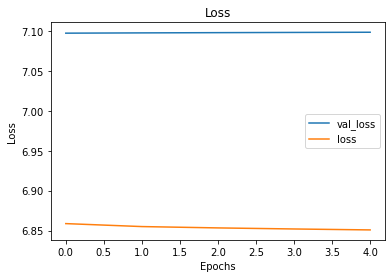

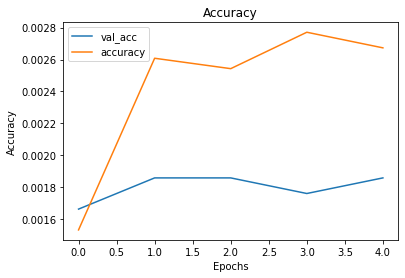

In [32]:
start = datetime.now()

gru_res=gru.fit(X_train_final,y_train,epochs=5,batch_size=100,validation_data=(X_val_final,y_val),
                class_weight = weight_dict_sorted,verbose=True)
end=datetime.now()

print('32 Nodes, time elapsed: ',end-start)
results_train = gru.evaluate(X_train_final,y_train)
print('----------')
print(f'Training Loss: {results_train[0]:.3} \nTraining Accuracy: {results_train[1]:.3}')
results_val = gru.evaluate(X_val_final,y_val)
print('----------')
print(f'Validation Loss: {results_val[0]:.3} \nValidation Accuracy: {results_val[1]:.3}')

visualize_training_results(gru_res)

gru.save_weights('saved_models/',save_format='h5')

LSTM,  0:17:20.432988
30675/30675 [==============================] - 365s 12ms/sample - loss: 6.8743 - accuracy: 0.0050
----------
Training Loss: 6.87 
Training Accuracy: 0.00499
10225/10225 [==============================] - 119s 12ms/sample - loss: 6.8751 - accuracy: 0.0056
----------
Validation Loss: 6.88 
Validation Accuracy: 0.00557


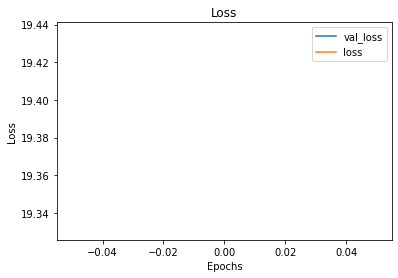

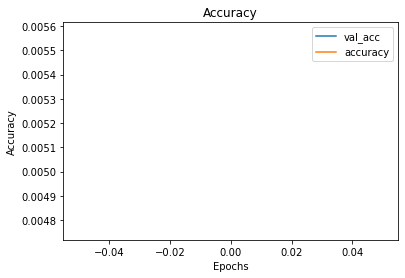

In [15]:
'''start = datetime.now()
lstm = keras.models.Sequential()
lstm.add(keras.layers.LSTM(64, input_shape=(3000,1,)))
lstm.add(keras.layers.Dense(y.shape[1],activation='softmax'))
lstm.compile(loss='categorical_crossentropy',optimizer='sgd',metrics=['accuracy'])



lstm_res=lstm.fit(X_train_final,y_train,epochs=1,batch_size=100,
                  validation_data=(X_val_final,y_val),class_weight = d_class_weights,verbose=True)'''
end=datetime.now()

print('LSTM, ',end-start)
results_train = lstm.evaluate(X_train_final,y_train)
print('----------')
print(f'Training Loss: {results_train[0]:.3} \nTraining Accuracy: {results_train[1]:.3}')
results_val = lstm.evaluate(X_val_final,y_val)
print('----------')
print(f'Validation Loss: {results_val[0]:.3} \nValidation Accuracy: {results_val[1]:.3}')

visualize_training_results(lstm_res)

  ...
    to  
  ['...']
  ...
    to  
  ['...']
Train on 30675 samples, validate on 10225 samples
Epoch 1/5
30675/30675 [==============================] - 1301s 42ms/sample - loss: 20.9734 - accuracy: 0.0311 - val_loss: 20.7489 - val_accuracy: 0.0366
Epoch 2/5
30675/30675 [==============================] - 1316s 43ms/sample - loss: 20.1173 - accuracy: 0.0352 - val_loss: 19.3856 - val_accuracy: 0.0373
Epoch 3/5
30675/30675 [==============================] - 1314s 43ms/sample - loss: 18.6650 - accuracy: 0.0325 - val_loss: 18.3431 - val_accuracy: 0.0375
Epoch 4/5
30675/30675 [==============================] - 1316s 43ms/sample - loss: 17.9524 - accuracy: 0.0338 - val_loss: 17.8986 - val_accuracy: 0.0369
Epoch 5/5
30675/30675 [==============================] - 1324s 43ms/sample - loss: 17.6150 - accuracy: 0.0319 - val_loss: 17.6752 - val_accuracy: 0.0374
LSTM, bidirectional, time elapsed:  1:50:20.696914
30675/30675 [==============================] - 259s 8ms/sample - loss: 5.9561 - accu

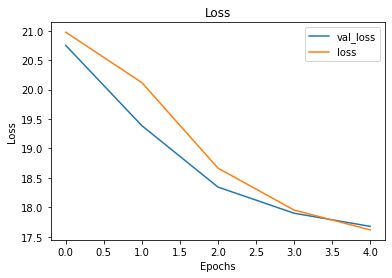

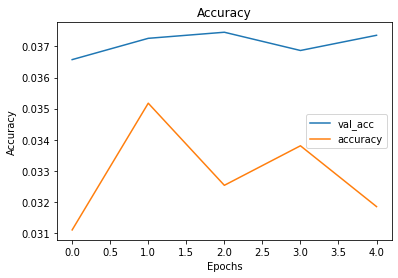

  ...
    to  
  ['...']
  ...
    to  
  ['...']
GRU, bidirectional, time elapsed:  2:11:17.335153
30675/30675 [==============================] - 374s 12ms/sample - loss: 5.9454 - accuracy: 0.0357
----------
Training Loss: 5.95 
Training Accuracy: 0.0357
10225/10225 [==============================] - 117s 11ms/sample - loss: 5.9570 - accuracy: 0.0373
----------
Validation Loss: 5.96 
Validation Accuracy: 0.0373


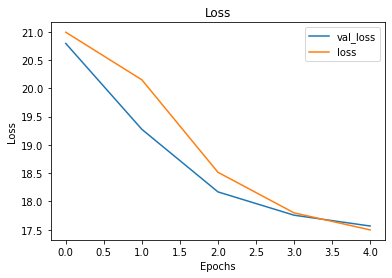

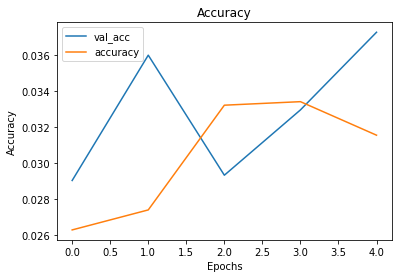

In [4]:
from time import time

start=datetime.now()
lstm = keras.models.Sequential()
lstm.add(keras.layers.Bidirectional(keras.layers.LSTM(16, input_shape=(3000,1,))))
lstm.add(keras.layers.Dense(y.shape[1],activation='softmax'))
lstm.compile(loss='categorical_crossentropy',optimizer='sgd',metrics=['accuracy'])



lstm_res=lstm.fit(X_train_final,y_train,epochs=5,batch_size=100,
                  validation_data=(X_val_final,y_val),class_weight = weight_dict_sorted,verbose=True)
end=datetime.now()
print('LSTM, bidirectional, time elapsed: ',end-start)
results_train = lstm.evaluate(X_train_final,y_train)
print('----------')
print(f'Training Loss: {results_train[0]:.3} \nTraining Accuracy: {results_train[1]:.3}')
results_val = lstm.evaluate(X_val_final,y_val)
print('----------')
print(f'Validation Loss: {results_val[0]:.3} \nValidation Accuracy: {results_val[1]:.3}')

visualize_training_results(lstm_res)


start = datetime.now()
gru = keras.models.Sequential()
gru.add(keras.layers.Bidirectional(keras.layers.GRU(16, input_shape=(3000,1,))))
gru.add(keras.layers.Dense(y.shape[1],activation='softmax'))
gru.compile(loss='categorical_crossentropy',optimizer='sgd',metrics=['accuracy'])



gru_res=gru.fit(X_train_final,y_train,epochs=5,batch_size=100,validation_data=(X_val_final,y_val),
                class_weight = weight_dict_sorted,verbose=False)
end=datetime.now()

print('GRU, bidirectional, time elapsed: ',end-start)
results_train = gru.evaluate(X_train_final,y_train)
print('----------')
print(f'Training Loss: {results_train[0]:.3} \nTraining Accuracy: {results_train[1]:.3}')
results_val = gru.evaluate(X_val_final,y_val)
print('----------')
print(f'Validation Loss: {results_val[0]:.3} \nValidation Accuracy: {results_val[1]:.3}')

visualize_training_results(gru_res)

  ...
    to  
  ['...']
  ...
    to  
  ['...']
LSTM, time elapsed:  1:58:34.657807
30675/30675 [==============================] - 199s 7ms/sample - loss: 5.9157 - accuracy: 0.0234
----------
Training Loss: 5.92 
Training Accuracy: 0.0234
10225/10225 [==============================] - 59s 6ms/sample - loss: 5.9268 - accuracy: 0.0208
----------
Validation Loss: 5.93 
Validation Accuracy: 0.0208


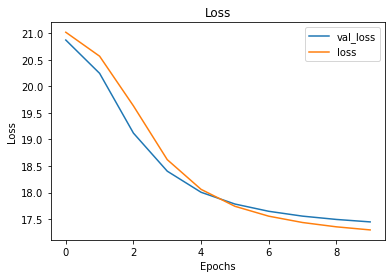

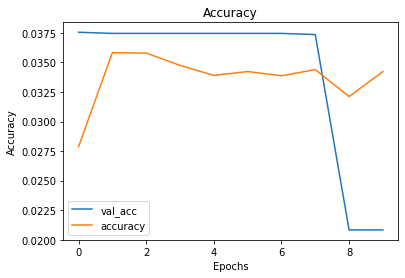

  ...
    to  
  ['...']
  ...
    to  
  ['...']
GRU, time elapsed:  1:54:54.970542
30675/30675 [==============================] - 214s 7ms/sample - loss: 5.9020 - accuracy: 0.0358
----------
Training Loss: 5.9 
Training Accuracy: 0.0358
10225/10225 [==============================] - 72s 7ms/sample - loss: 5.9134 - accuracy: 0.0375
----------
Validation Loss: 5.91 
Validation Accuracy: 0.0375


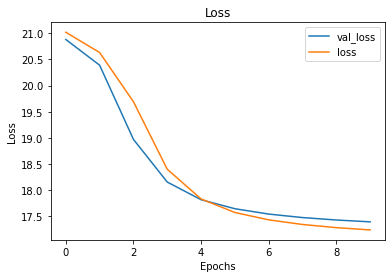

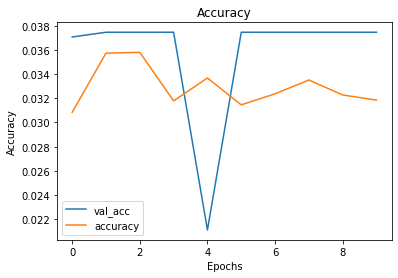

In [5]:
start=datetime.now()
lstm = keras.models.Sequential()
lstm.add(keras.layers.LSTM(16, input_shape=(3000,1,)))
lstm.add(keras.layers.Dense(y.shape[1],activation='softmax'))
lstm.compile(loss='categorical_crossentropy',optimizer='sgd',metrics=['accuracy'])



lstm_res=lstm.fit(X_train_final,y_train,epochs=10,batch_size=100,
                  validation_data=(X_val_final,y_val),class_weight = weight_dict_sorted,verbose=False)
end=datetime.now()
print('LSTM, time elapsed: ',end-start)
results_train = lstm.evaluate(X_train_final,y_train)
print('----------')
print(f'Training Loss: {results_train[0]:.3} \nTraining Accuracy: {results_train[1]:.3}')
results_val = lstm.evaluate(X_val_final,y_val)
print('----------')
print(f'Validation Loss: {results_val[0]:.3} \nValidation Accuracy: {results_val[1]:.3}')

visualize_training_results(lstm_res)


start = datetime.now()
gru = keras.models.Sequential()
gru.add(keras.layers.GRU(16, input_shape=(3000,1,)))
gru.add(keras.layers.Dense(y.shape[1],activation='softmax'))
gru.compile(loss='categorical_crossentropy',optimizer='sgd',metrics=['accuracy'])



gru_res=gru.fit(X_train_final,y_train,epochs=10,batch_size=100,
                validation_data=(X_val_final,y_val),class_weight = weight_dict_sorted,verbose=False)
end=datetime.now()

print('GRU, time elapsed: ',end-start)
results_train = gru.evaluate(X_train_final,y_train)
print('----------')
print(f'Training Loss: {results_train[0]:.3} \nTraining Accuracy: {results_train[1]:.3}')
results_val = gru.evaluate(X_val_final,y_val)
print('----------')
print(f'Validation Loss: {results_val[0]:.3} \nValidation Accuracy: {results_val[1]:.3}')

visualize_training_results(gru_res)

GRU with bidirectional best, approx 4% accuracy

  ...
    to  
  ['...']
  ...
    to  
  ['...']
Train on 30675 samples, validate on 10225 samples
Epoch 1/10
30675/30675 [==============================] - 1858s 61ms/sample - loss: 15.8568 - accuracy: 0.0340 - val_loss: 15.3366 - val_accuracy: 0.0361
Epoch 2/10
30675/30675 [==============================] - 1818s 59ms/sample - loss: 14.6059 - accuracy: 0.0363 - val_loss: 13.7104 - val_accuracy: 0.0361
Epoch 3/10
30675/30675 [==============================] - 1815s 59ms/sample - loss: 13.5676 - accuracy: 0.0363 - val_loss: 13.2256 - val_accuracy: 0.0361
Epoch 4/10
30675/30675 [==============================] - 1821s 59ms/sample - loss: 13.2003 - accuracy: 0.0363 - val_loss: 12.9619 - val_accuracy: 0.0361
Epoch 5/10
30675/30675 [==============================] - 1805s 59ms/sample - loss: 12.9953 - accuracy: 0.0363 - val_loss: 12.8463 - val_accuracy: 0.0361
Epoch 6/10
30675/30675 [==============================] - 1816s 59ms/sample - loss: 12.8933 - accuracy: 0.0363 - val_loss: 12.7855

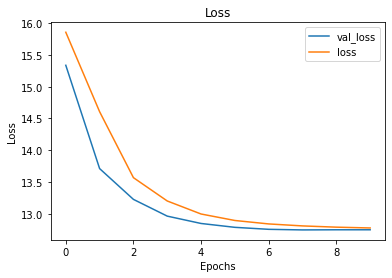

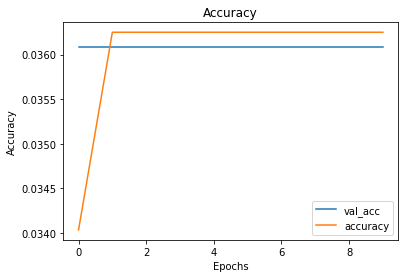

  ...
    to  
  ['...']
  ...
    to  
  ['...']
Train on 30675 samples, validate on 10225 samples
Epoch 1/10
30675/30675 [==============================] - 1807s 59ms/sample - loss: 16.0491 - accuracy: 0.0263 - val_loss: 15.7337 - val_accuracy: 0.0354
Epoch 2/10
30675/30675 [==============================] - 1694s 55ms/sample - loss: 14.4242 - accuracy: 0.0360 - val_loss: 13.1497 - val_accuracy: 0.0361
Epoch 3/10
30675/30675 [==============================] - 1677s 55ms/sample - loss: 13.0182 - accuracy: 0.0363 - val_loss: 12.8538 - val_accuracy: 0.0361
Epoch 4/10
30675/30675 [==============================] - 1438s 47ms/sample - loss: 12.8678 - accuracy: 0.0363 - val_loss: 12.7881 - val_accuracy: 0.0361
Epoch 5/10
30675/30675 [==============================] - 1589s 52ms/sample - loss: 12.8153 - accuracy: 0.0363 - val_loss: 12.7564 - val_accuracy: 0.0361
Epoch 6/10
30675/30675 [==============================] - 1469s 48ms/sample - loss: 12.7850 - accuracy: 0.0363 - val_loss: 12.7374

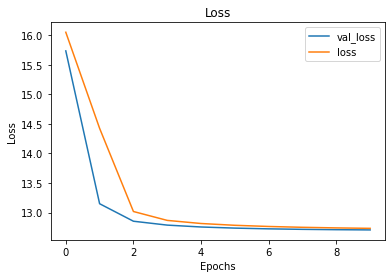

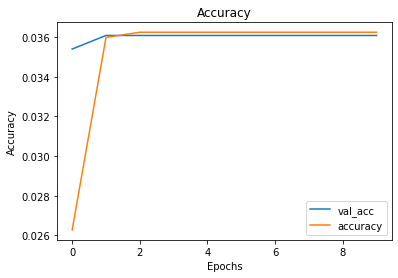

  ...
    to  
  ['...']
  ...
    to  
  ['...']
Train on 30675 samples, validate on 10225 samples
Epoch 1/10
30675/30675 [==============================] - 1546s 50ms/sample - loss: 13.5251 - accuracy: 0.0340 - val_loss: 12.7746 - val_accuracy: 0.0361
Epoch 2/10
30675/30675 [==============================] - 1758s 57ms/sample - loss: 12.7889 - accuracy: 0.0363 - val_loss: 12.7162 - val_accuracy: 0.0361
Epoch 3/10
30675/30675 [==============================] - 1828s 60ms/sample - loss: 12.7212 - accuracy: 0.0363 - val_loss: 12.6539 - val_accuracy: 0.0361
Epoch 4/10
30675/30675 [==============================] - 1806s 59ms/sample - loss: 12.6173 - accuracy: 0.0363 - val_loss: 12.5805 - val_accuracy: 0.0361
Epoch 5/10
30675/30675 [==============================] - 1811s 59ms/sample - loss: 12.5296 - accuracy: 0.0363 - val_loss: 12.5828 - val_accuracy: 0.0362
Epoch 6/10
30675/30675 [==============================] - 1808s 59ms/sample - loss: 12.3916 - accuracy: 0.0363 - val_loss: 12.4086

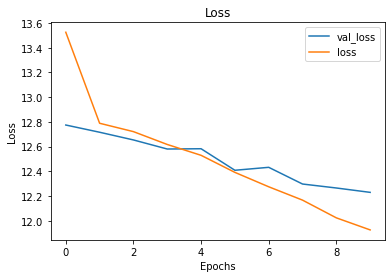

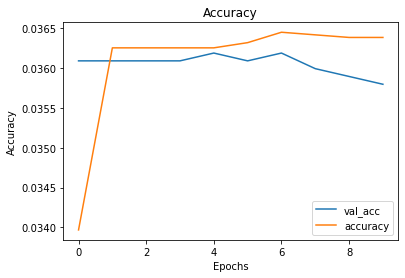

In [4]:
start = datetime.now()
gru = keras.models.Sequential()
gru.add(keras.layers.Bidirectional(keras.layers.GRU(32, input_shape=(3000,1,))))
gru.add(keras.layers.Dense(y.shape[1],activation='softmax'))
gru.compile(loss='categorical_crossentropy',optimizer='sgd',metrics=['accuracy'])



gru_res=gru.fit(X_train_final,y_train,epochs=10,batch_size=100,validation_data=(X_val_final,y_val),
                class_weight = d_class_weights,verbose=True)
end=datetime.now()

print('SGD, time elapsed: ',end-start)
results_train = gru.evaluate(X_train_final,y_train)
print('----------')
print(f'Training Loss: {results_train[0]:.3} \nTraining Accuracy: {results_train[1]:.3}')
results_val = gru.evaluate(X_val_final,y_val)
print('----------')
print(f'Validation Loss: {results_val[0]:.3} \nValidation Accuracy: {results_val[1]:.3}')

visualize_training_results(gru_res)

start = datetime.now()
gru = keras.models.Sequential()
gru.add(keras.layers.Bidirectional(keras.layers.GRU(32, input_shape=(3000,1,))))
gru.add(keras.layers.Dense(y.shape[1],activation='softmax'))
gru.compile(loss='categorical_crossentropy',optimizer='Adagrad',metrics=['accuracy'])



gru_res=gru.fit(X_train_final,y_train,epochs=10,batch_size=100,validation_data=(X_val_final,y_val),
                class_weight = d_class_weights,verbose=True)
end=datetime.now()

print('Adagrad, time elapsed: ',end-start)
results_train = gru.evaluate(X_train_final,y_train)
print('----------')
print(f'Training Loss: {results_train[0]:.3} \nTraining Accuracy: {results_train[1]:.3}')
results_val = gru.evaluate(X_val_final,y_val)
print('----------')
print(f'Validation Loss: {results_val[0]:.3} \nValidation Accuracy: {results_val[1]:.3}')

visualize_training_results(gru_res)

start = datetime.now()
gru = keras.models.Sequential()
gru.add(keras.layers.Bidirectional(keras.layers.GRU(32, input_shape=(3000,1,))))
gru.add(keras.layers.Dense(y.shape[1],activation='softmax'))
gru.compile(loss='categorical_crossentropy',optimizer='Nadam',metrics=['accuracy'])



gru_res=gru.fit(X_train_final,y_train,epochs=10,batch_size=100,validation_data=(X_val_final,y_val),
                class_weight = d_class_weights,verbose=True)
end=datetime.now()

print('Nadam, time elapsed: ',end-start)
results_train = gru.evaluate(X_train_final,y_train)
print('----------')
print(f'Training Loss: {results_train[0]:.3} \nTraining Accuracy: {results_train[1]:.3}')
results_val = gru.evaluate(X_val_final,y_val)
print('----------')
print(f'Validation Loss: {results_val[0]:.3} \nValidation Accuracy: {results_val[1]:.3}')

visualize_training_results(gru_res)

  ...
    to  
  ['...']
  ...
    to  
  ['...']
Train on 30675 samples, validate on 10225 samples
Epoch 1/5
30675/30675 [==============================] - 1605s 52ms/sample - loss: 21.0683 - accuracy: 0.0166 - val_loss: 21.1549 - val_accuracy: 0.0227
Epoch 2/5
30675/30675 [==============================] - 1618s 53ms/sample - loss: 20.8613 - accuracy: 0.0274 - val_loss: 20.8470 - val_accuracy: 0.0289
Epoch 3/5
30675/30675 [==============================] - 1626s 53ms/sample - loss: 20.2102 - accuracy: 0.0328 - val_loss: 19.8711 - val_accuracy: 0.0313
Epoch 4/5
30675/30675 [==============================] - 1645s 54ms/sample - loss: 19.2068 - accuracy: 0.0355 - val_loss: 18.8899 - val_accuracy: 0.0358
Epoch 5/5
30675/30675 [==============================] - 1645s 54ms/sample - loss: 18.2750 - accuracy: 0.0365 - val_loss: 18.1993 - val_accuracy: 0.0352
16 Nodes, time elapsed:  2:15:50.670349
30675/30675 [==============================] - 360s 12ms/sample - loss: 6.0409 - accuracy: 0.03

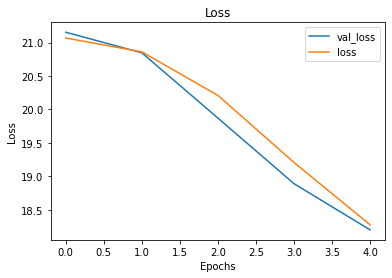

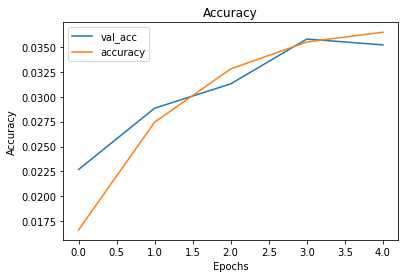

  ...
    to  
  ['...']
  ...
    to  
  ['...']
Train on 30675 samples, validate on 10225 samples
Epoch 1/5
30675/30675 [==============================] - 1976s 64ms/sample - loss: 20.8484 - accuracy: 0.0263 - val_loss: 19.8273 - val_accuracy: 0.0368
Epoch 2/5
30675/30675 [==============================] - 1793s 58ms/sample - loss: 17.9977 - accuracy: 0.0369 - val_loss: 17.5652 - val_accuracy: 0.0353
Epoch 3/5
30675/30675 [==============================] - 1793s 58ms/sample - loss: 17.1782 - accuracy: 0.0365 - val_loss: 17.3852 - val_accuracy: 0.0353
Epoch 4/5
30675/30675 [==============================] - 1812s 59ms/sample - loss: 17.0743 - accuracy: 0.0365 - val_loss: 17.3406 - val_accuracy: 0.0353
Epoch 5/5
30675/30675 [==============================] - 1845s 60ms/sample - loss: 17.0398 - accuracy: 0.0365 - val_loss: 17.3232 - val_accuracy: 0.0353
32 Nodes, time elapsed:  2:34:56.311251
30675/30675 [==============================] - 530s 17ms/sample - loss: 5.9205 - accuracy: 0.03

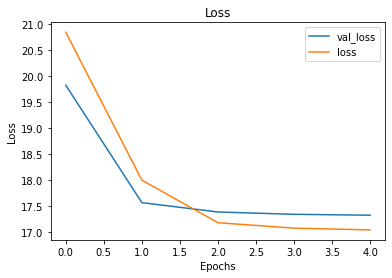

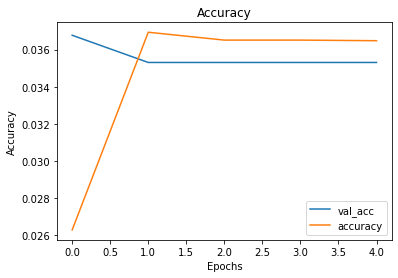

In [5]:
start = datetime.now()
gru = keras.models.Sequential()
gru.add(keras.layers.Bidirectional(keras.layers.GRU(16, input_shape=(3000,1,))))
gru.add(keras.layers.Dense(y.shape[1],activation='softmax'))
gru.compile(loss='categorical_crossentropy',optimizer='Adagrad',metrics=['accuracy'])



gru_res=gru.fit(X_train_final,y_train,epochs=5,batch_size=100,validation_data=(X_val_final,y_val),
                class_weight = weight_dict_sorted,verbose=True)
end=datetime.now()

print('16 Nodes, time elapsed: ',end-start)
results_train = gru.evaluate(X_train_final,y_train)
print('----------')
print(f'Training Loss: {results_train[0]:.3} \nTraining Accuracy: {results_train[1]:.3}')
results_val = gru.evaluate(X_val_final,y_val)
print('----------')
print(f'Validation Loss: {results_val[0]:.3} \nValidation Accuracy: {results_val[1]:.3}')

visualize_training_results(gru_res)

start = datetime.now()
gru = keras.models.Sequential()
gru.add(keras.layers.Bidirectional(keras.layers.GRU(32, input_shape=(3000,1,))))
gru.add(keras.layers.Dense(y.shape[1],activation='softmax'))
gru.compile(loss='categorical_crossentropy',optimizer='Adagrad',metrics=['accuracy'])



gru_res=gru.fit(X_train_final,y_train,epochs=5,batch_size=100,validation_data=(X_val_final,y_val),
                class_weight = weight_dict_sorted,verbose=True)
end=datetime.now()

print('32 Nodes, time elapsed: ',end-start)
results_train = gru.evaluate(X_train_final,y_train)
print('----------')
print(f'Training Loss: {results_train[0]:.3} \nTraining Accuracy: {results_train[1]:.3}')
results_val = gru.evaluate(X_val_final,y_val)
print('----------')
print(f'Validation Loss: {results_val[0]:.3} \nValidation Accuracy: {results_val[1]:.3}')

visualize_training_results(gru_res)



In [6]:
gru.save('temp_model_32Nodes')

Instructions for updating:
If using Keras pass *_constraint arguments to layers.
INFO:tensorflow:Assets written to: temp_model_32Nodes\assets


  ...
    to  
  ['...']


  ...
    to  
  ['...']


  ...
    to  
  ['...']


  ...
    to  
  ['...']


Train on 30675 samples, validate on 10225 samples
Epoch 1/5
30675/30675 [==============================] - 1325s 43ms/sample - loss: 16.4934 - accuracy: 0.0351 - val_loss: 15.5763 - val_accuracy: 0.0351
Epoch 2/5
30675/30675 [==============================] - 1569s 51ms/sample - loss: 15.4687 - accuracy: 0.0360 - val_loss: 15.5570 - val_accuracy: 0.0351
Epoch 3/5
30675/30675 [==============================] - 1573s 51ms/sample - loss: 15.4516 - accuracy: 0.0339 - val_loss: 15.5461 - val_accuracy: 0.0351
Epoch 4/5
30675/30675 [==============================] - 1405s 46ms/sample - loss: 15.4449 - accuracy: 0.0332 - val_loss: 15.5388 - val_accuracy: 0.0351
Epoch 5/5
30675/30675 [==============================] - 1566s 51ms/sample - loss: 15.4360 - accuracy: 0.0341 - val_loss: 15.5234 - val_accuracy: 0.0351
Nadam, time elapsed:  2:17:31.690787
30675/30675 [==============================] - 299s 10ms/sample - loss: 6.4333 - accuracy: 0.0366
----------
Training Loss: 6.43 
Training Accuracy:

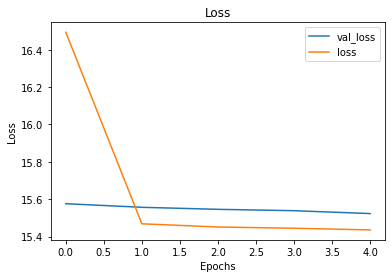

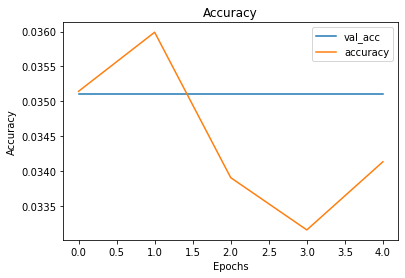

In [8]:
start = datetime.now()
gru = keras.models.Sequential()
gru.add(keras.layers.Bidirectional(keras.layers.GRU(8, input_shape=(3000,1,))))
gru.add(keras.layers.Reshape((16,1)))
gru.add(keras.layers.Bidirectional(keras.layers.GRU(8)))
gru.add(keras.layers.Dense(y.shape[1],activation='softmax'))
gru.compile(loss='categorical_crossentropy',optimizer='Nadam',metrics=['accuracy'])



gru_res=gru.fit(X_train_final,y_train,epochs=5,batch_size=100,validation_data=(X_val_final,y_val),
                class_weight = d_class_weights,verbose=True)
end=datetime.now()

print('Nadam, time elapsed: ',end-start)
results_train = gru.evaluate(X_train_final,y_train)
print('----------')
print(f'Training Loss: {results_train[0]:.3} \nTraining Accuracy: {results_train[1]:.3}')
results_val = gru.evaluate(X_val_final,y_val)
print('----------')
print(f'Validation Loss: {results_val[0]:.3} \nValidation Accuracy: {results_val[1]:.3}')

visualize_training_results(gru_res)

Compare a variety of optimizers:
* sgd (above) - Train Loss: 7.5, Val Loss: 9
* RMSprop - 10.5, 13
* Adam - 9, 11.5
* Nadam - 13, 15
* Adagrad - 6.4, 10
* Adamax - 8, 10

RMSprop
30675/30675 [==============================] - 16s 515us/step
----------
Training Loss: 10.5 
Training Accuracy: 0.176
10225/10225 [==============================] - 5s 533us/step
----------
Validation Loss: 12.8 
Validation Accuracy: 0.00714


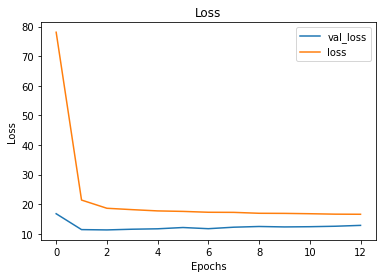

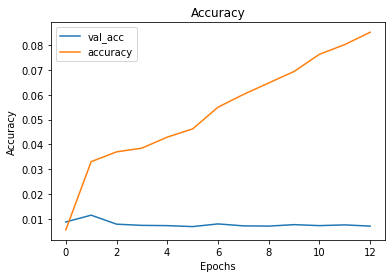

Adam
30675/30675 [==============================] - 16s 507us/step
----------
Training Loss: 9.19 
Training Accuracy: 0.2
10225/10225 [==============================] - 5s 522us/step
----------
Validation Loss: 11.6 
Validation Accuracy: 0.00655


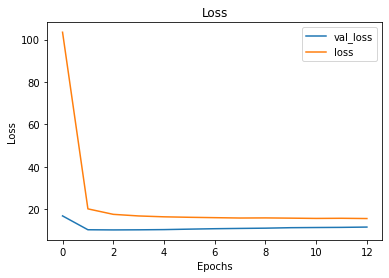

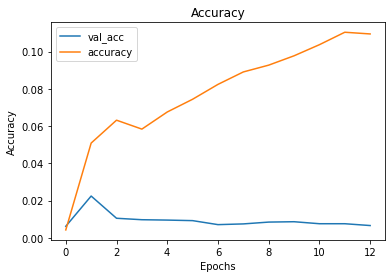

Nadam
30675/30675 [==============================] - 16s 509us/step
----------
Training Loss: 13.2 
Training Accuracy: 0.133
10225/10225 [==============================] - 5s 517us/step
----------
Validation Loss: 15.3 
Validation Accuracy: 0.0045


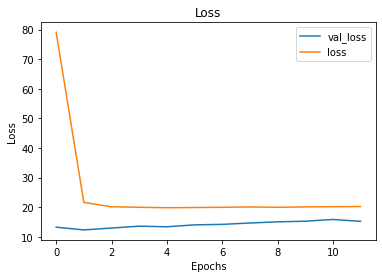

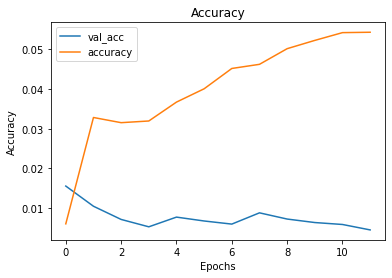

Adagrad
30675/30675 [==============================] - 16s 512us/step
----------
Training Loss: 6.41 
Training Accuracy: 0.344
10225/10225 [==============================] - 5s 500us/step
----------
Validation Loss: 10.3 
Validation Accuracy: 0.00831


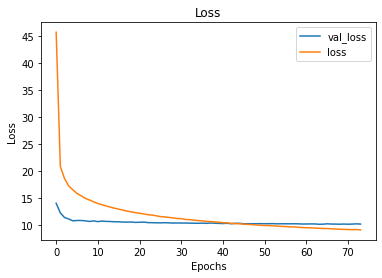

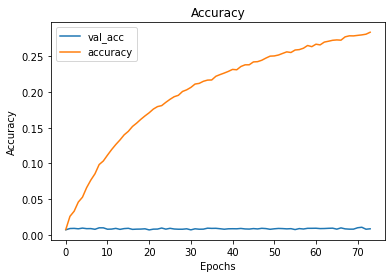

Adamax
30675/30675 [==============================] - 15s 502us/step
----------
Training Loss: 8.17 
Training Accuracy: 0.206
10225/10225 [==============================] - 5s 498us/step
----------
Validation Loss: 10.4 
Validation Accuracy: 0.00753


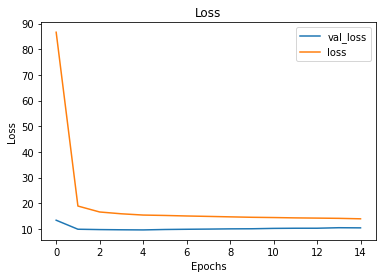

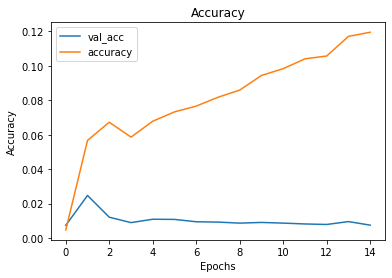

In [4]:
# Testing optimizers

RMSprop_model = models.Sequential()
RMSprop_model.add(layers.Dropout(0.1,input_shape=(3000,)))
RMSprop_model.add(layers.Dense(2000,activation='tanh',kernel_regularizer=regularizers.l2(0.1)))
RMSprop_model.add(layers.Dense(y.shape[1],activation='softmax'))
RMSprop_model.compile(loss='categorical_crossentropy',optimizer='RMSprop',metrics=['accuracy'])



results=RMSprop_model.fit(X_train_scale,y_train,epochs=100,batch_size=1000,validation_data=(X_val_scale,y_val),
                       callbacks=early_stopping,class_weight = d_class_weights,verbose=False)

print('RMSprop')
results_train = RMSprop_model.evaluate(X_train_scale,y_train)
print('----------')
print(f'Training Loss: {results_train[0]:.3} \nTraining Accuracy: {results_train[1]:.3}')
results_val = RMSprop_model.evaluate(X_val_scale,y_val)
print('----------')
print(f'Validation Loss: {results_val[0]:.3} \nValidation Accuracy: {results_val[1]:.3}')

visualize_training_results(results)


adam_model = models.Sequential()
adam_model.add(layers.Dropout(0.1,input_shape=(3000,)))
adam_model.add(layers.Dense(2000,activation='tanh',kernel_regularizer=regularizers.l2(0.1)))
adam_model.add(layers.Dense(y.shape[1],activation='softmax'))
adam_model.compile(loss='categorical_crossentropy',optimizer='Adam',metrics=['accuracy'])



results=adam_model.fit(X_train_scale,y_train,epochs=100,batch_size=1000,validation_data=(X_val_scale,y_val),
                       callbacks=early_stopping,class_weight = d_class_weights,verbose=False)

print('Adam')
results_train = adam_model.evaluate(X_train_scale,y_train)
print('----------')
print(f'Training Loss: {results_train[0]:.3} \nTraining Accuracy: {results_train[1]:.3}')
results_val = adam_model.evaluate(X_val_scale,y_val)
print('----------')
print(f'Validation Loss: {results_val[0]:.3} \nValidation Accuracy: {results_val[1]:.3}')

visualize_training_results(results)


nadam_model = models.Sequential()
nadam_model.add(layers.Dropout(0.1,input_shape=(3000,)))
nadam_model.add(layers.Dense(2000,activation='tanh',kernel_regularizer=regularizers.l2(0.1)))
nadam_model.add(layers.Dense(y.shape[1],activation='softmax'))
nadam_model.compile(loss='categorical_crossentropy',optimizer='Nadam',metrics=['accuracy'])



results=nadam_model.fit(X_train_scale,y_train,epochs=100,batch_size=1000,validation_data=(X_val_scale,y_val),
                       callbacks=early_stopping,class_weight = d_class_weights,verbose=False)

print('Nadam')
results_train = nadam_model.evaluate(X_train_scale,y_train)
print('----------')
print(f'Training Loss: {results_train[0]:.3} \nTraining Accuracy: {results_train[1]:.3}')
results_val = nadam_model.evaluate(X_val_scale,y_val)
print('----------')
print(f'Validation Loss: {results_val[0]:.3} \nValidation Accuracy: {results_val[1]:.3}')

visualize_training_results(results)


adagrad_model = models.Sequential()
adagrad_model.add(layers.Dropout(0.1,input_shape=(3000,)))
adagrad_model.add(layers.Dense(2000,activation='tanh',kernel_regularizer=regularizers.l2(0.1)))
adagrad_model.add(layers.Dense(y.shape[1],activation='softmax'))
adagrad_model.compile(loss='categorical_crossentropy',optimizer='Adagrad',metrics=['accuracy'])



results=adagrad_model.fit(X_train_scale,y_train,epochs=100,batch_size=1000,validation_data=(X_val_scale,y_val),
                       callbacks=early_stopping,class_weight = d_class_weights,verbose=False)

print('Adagrad')
results_train = adagrad_model.evaluate(X_train_scale,y_train)
print('----------')
print(f'Training Loss: {results_train[0]:.3} \nTraining Accuracy: {results_train[1]:.3}')
results_val = adagrad_model.evaluate(X_val_scale,y_val)
print('----------')
print(f'Validation Loss: {results_val[0]:.3} \nValidation Accuracy: {results_val[1]:.3}')

visualize_training_results(results)


adamax_model = models.Sequential()
adamax_model.add(layers.Dropout(0.1,input_shape=(3000,)))
adamax_model.add(layers.Dense(2000,activation='tanh',kernel_regularizer=regularizers.l2(0.1)))
adamax_model.add(layers.Dense(y.shape[1],activation='softmax'))
adamax_model.compile(loss='categorical_crossentropy',optimizer='Adamax',metrics=['accuracy'])



results=adamax_model.fit(X_train_scale,y_train,epochs=100,batch_size=1000,validation_data=(X_val_scale,y_val),
                       callbacks=early_stopping,class_weight = d_class_weights,verbose=False)

print('Adamax')
results_train = adamax_model.evaluate(X_train_scale,y_train)
print('----------')
print(f'Training Loss: {results_train[0]:.3} \nTraining Accuracy: {results_train[1]:.3}')
results_val = adamax_model.evaluate(X_val_scale,y_val)
print('----------')
print(f'Validation Loss: {results_val[0]:.3} \nValidation Accuracy: {results_val[1]:.3}')

visualize_training_results(results)

tanh
30675/30675 [==============================] - 159s 5ms/step
----------
Training Loss: 6.41 
Training Accuracy: 0.344
10225/10225 [==============================] - 48s 5ms/step
----------
Validation Loss: 10.3 
Validation Accuracy: 0.00831
ReLU
30675/30675 [==============================] - 18s 577us/step
----------
Training Loss: 8.81 
Training Accuracy: 0.231
10225/10225 [==============================] - 6s 580us/step
----------
Validation Loss: 11.0 
Validation Accuracy: 0.0106


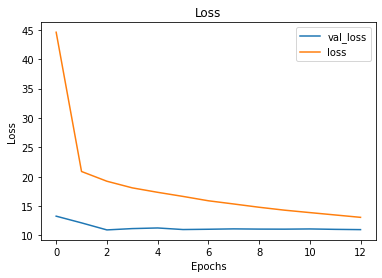

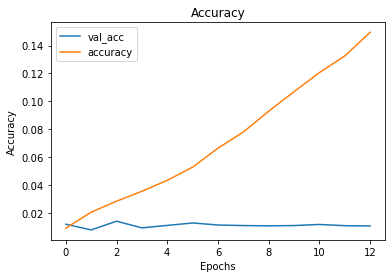

Leaky ReLU
30675/30675 [==============================] - 15s 491us/step
----------
Training Loss: 8.54 
Training Accuracy: 0.215
10225/10225 [==============================] - 5s 473us/step
----------
Validation Loss: 10.9 
Validation Accuracy: 0.00939


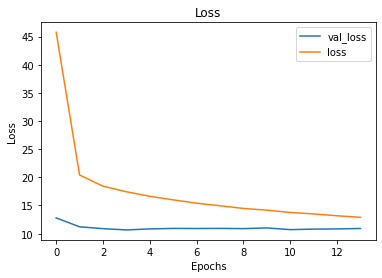

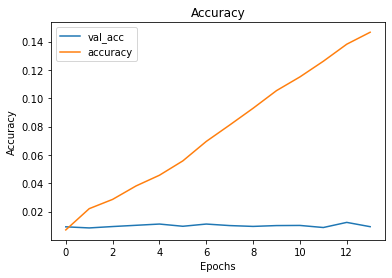

Thresholded ReLU
30675/30675 [==============================] - 15s 504us/step
----------
Training Loss: 6.46 
Training Accuracy: 0.0193
10225/10225 [==============================] - 5s 495us/step
----------
Validation Loss: 6.46 
Validation Accuracy: 0.0199


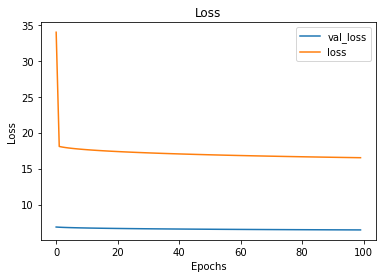

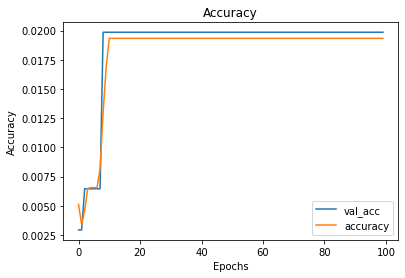

In [5]:
# testing activation functions
# tanh, relu, ThresholdedReLU, LeakyReLU
print('tanh')
results_train = adagrad_model.evaluate(X_train_scale,y_train)
print('----------')
print(f'Training Loss: {results_train[0]:.3} \nTraining Accuracy: {results_train[1]:.3}')
results_val = adagrad_model.evaluate(X_val_scale,y_val)
print('----------')
print(f'Validation Loss: {results_val[0]:.3} \nValidation Accuracy: {results_val[1]:.3}')


relu_model = models.Sequential()
relu_model.add(layers.Dropout(0.1,input_shape=(3000,)))
relu_model.add(layers.Dense(2000,activation='relu',kernel_regularizer=regularizers.l2(0.1)))
relu_model.add(layers.Dense(y.shape[1],activation='softmax'))
relu_model.compile(loss='categorical_crossentropy',optimizer='Adagrad',metrics=['accuracy'])



results=relu_model.fit(X_train_scale,y_train,epochs=100,batch_size=1000,validation_data=(X_val_scale,y_val),
                       callbacks=early_stopping,class_weight = d_class_weights,verbose=False)

print('ReLU')
results_train = relu_model.evaluate(X_train_scale,y_train)
print('----------')
print(f'Training Loss: {results_train[0]:.3} \nTraining Accuracy: {results_train[1]:.3}')
results_val = relu_model.evaluate(X_val_scale,y_val)
print('----------')
print(f'Validation Loss: {results_val[0]:.3} \nValidation Accuracy: {results_val[1]:.3}')

visualize_training_results(results)


leaky_model = models.Sequential()
leaky_model.add(layers.Dropout(0.1,input_shape=(3000,)))
leaky_model.add(layers.Dense(2000,kernel_regularizer=regularizers.l2(0.1)))
leaky_model.add(layers.LeakyReLU())
leaky_model.add(layers.Dense(y.shape[1],activation='softmax'))
leaky_model.compile(loss='categorical_crossentropy',optimizer='Adagrad',metrics=['accuracy'])



results=leaky_model.fit(X_train_scale,y_train,epochs=100,batch_size=1000,validation_data=(X_val_scale,y_val),
                       callbacks=early_stopping,class_weight = d_class_weights,verbose=False)

print('Leaky ReLU')
results_train = leaky_model.evaluate(X_train_scale,y_train)
print('----------')
print(f'Training Loss: {results_train[0]:.3} \nTraining Accuracy: {results_train[1]:.3}')
results_val = leaky_model.evaluate(X_val_scale,y_val)
print('----------')
print(f'Validation Loss: {results_val[0]:.3} \nValidation Accuracy: {results_val[1]:.3}')

visualize_training_results(results)


thresh_model = models.Sequential()
thresh_model.add(layers.Dropout(0.1,input_shape=(3000,)))
thresh_model.add(layers.Dense(2000,kernel_regularizer=regularizers.l2(0.1)))
thresh_model.add(layers.ThresholdedReLU())
thresh_model.add(layers.Dense(y.shape[1],activation='softmax'))
thresh_model.compile(loss='categorical_crossentropy',optimizer='Adagrad',metrics=['accuracy'])



results=thresh_model.fit(X_train_scale,y_train,epochs=100,batch_size=1000,validation_data=(X_val_scale,y_val),
                       callbacks=early_stopping,class_weight = d_class_weights,verbose=False)

print('Thresholded ReLU')
results_train = thresh_model.evaluate(X_train_scale,y_train)
print('----------')
print(f'Training Loss: {results_train[0]:.3} \nTraining Accuracy: {results_train[1]:.3}')
results_val = thresh_model.evaluate(X_val_scale,y_val)
print('----------')
print(f'Validation Loss: {results_val[0]:.3} \nValidation Accuracy: {results_val[1]:.3}')

visualize_training_results(results)

sgd
30675/30675 [==============================] - 16s 535us/step
----------
Training Loss: 6.71 
Training Accuracy: 0.0226
10225/10225 [==============================] - 5s 524us/step
----------
Validation Loss: 6.74 
Validation Accuracy: 0.0199


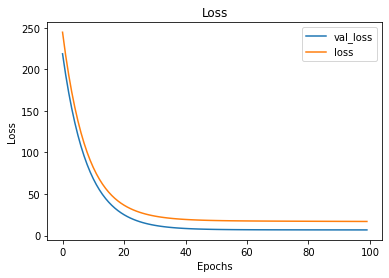

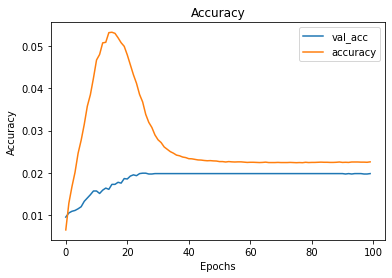

In [6]:
sgd_model = models.Sequential()
sgd_model.add(layers.Dropout(0.1,input_shape=(3000,)))
sgd_model.add(layers.Dense(2000,kernel_regularizer=regularizers.l2(0.1)))
sgd_model.add(layers.ThresholdedReLU())
sgd_model.add(layers.Dense(y.shape[1],activation='softmax'))
sgd_model.compile(loss='categorical_crossentropy',optimizer='sgd',metrics=['accuracy'])



results=sgd_model.fit(X_train_scale,y_train,epochs=100,batch_size=1000,validation_data=(X_val_scale,y_val),
                       callbacks=early_stopping,class_weight = d_class_weights,verbose=False)

print('sgd')
results_train = sgd_model.evaluate(X_train_scale,y_train)
print('----------')
print(f'Training Loss: {results_train[0]:.3} \nTraining Accuracy: {results_train[1]:.3}')
results_val = sgd_model.evaluate(X_val_scale,y_val)
print('----------')
print(f'Validation Loss: {results_val[0]:.3} \nValidation Accuracy: {results_val[1]:.3}')

visualize_training_results(results)

  ...
    to  
  ['...']
  ...
    to  
  ['...']
Three Hidden Layers (equal size)
30675/30675 [==============================] - 31s 1ms/sample - loss: 7.3837 - accuracy: 0.0227
----------
Training Loss: 7.38 
Training Accuracy: 0.0227
10225/10225 [==============================] - 10s 983us/sample - loss: 7.5590 - accuracy: 0.0134
----------
Validation Loss: 7.56 
Validation Accuracy: 0.0134


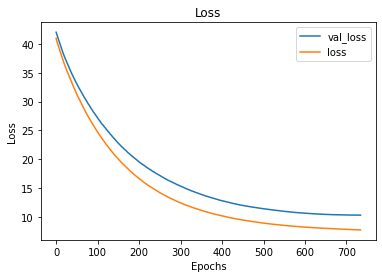

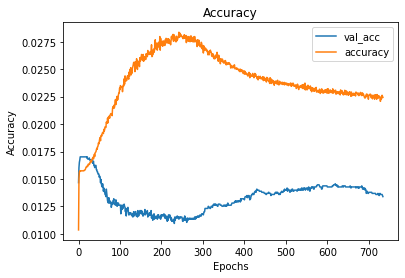

  ...
    to  
  ['...']
  ...
    to  
  ['...']
Three Hidden Layers (decreasing size)
30675/30675 [==============================] - 36s 1ms/sample - loss: 7.4136 - accuracy: 0.0209s - loss: 7.4143 - accu
----------
Training Loss: 7.41 
Training Accuracy: 0.0209
10225/10225 [==============================] - 10s 962us/sample - loss: 7.6435 - accuracy: 0.0032- loss: 7.6466 - accu
----------
Validation Loss: 7.64 
Validation Accuracy: 0.00323


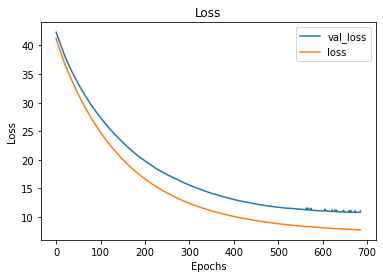

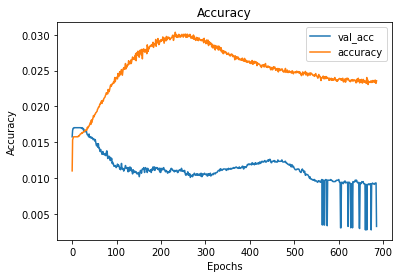

In [5]:
HL_3 = models.Sequential()
HL_3.add(layers.Dropout(0.1,input_shape=(3000,)))
HL_3.add(layers.Dense(2000,kernel_regularizer=regularizers.l2(0.005)))
HL_3.add(layers.ThresholdedReLU())
HL_3.add(layers.Dense(2000,kernel_regularizer=regularizers.l2(0.005)))
HL_3.add(layers.ThresholdedReLU())
HL_3.add(layers.Dense(2000,kernel_regularizer=regularizers.l2(0.005)))
HL_3.add(layers.ThresholdedReLU())
HL_3.add(layers.Dense(y.shape[1],activation='softmax'))
HL_3.compile(loss='categorical_crossentropy',optimizer='sgd',metrics=['accuracy'])



results=HL_3.fit(X_train_scale,y_train,epochs=1000,batch_size=1000,validation_data=(X_val_scale,y_val),
                       callbacks=early_stopping,class_weight = d_class_weights,verbose=False)

print('Three Hidden Layers (equal size)')
results_train = HL_3.evaluate(X_train_scale,y_train)
print('----------')
print(f'Training Loss: {results_train[0]:.3} \nTraining Accuracy: {results_train[1]:.3}')
results_val = HL_3.evaluate(X_val_scale,y_val)
print('----------')
print(f'Validation Loss: {results_val[0]:.3} \nValidation Accuracy: {results_val[1]:.3}')

visualize_training_results(results)


HL_dec = models.Sequential()
HL_dec.add(layers.Dropout(0.1,input_shape=(3000,)))
HL_dec.add(layers.Dense(2300,kernel_regularizer=regularizers.l2(0.005)))
HL_dec.add(layers.ThresholdedReLU())
HL_dec.add(layers.Dense(2000,kernel_regularizer=regularizers.l2(0.005)))
HL_dec.add(layers.ThresholdedReLU())
HL_dec.add(layers.Dense(1500,kernel_regularizer=regularizers.l2(0.005)))
HL_dec.add(layers.ThresholdedReLU())
HL_dec.add(layers.Dense(y.shape[1],activation='softmax'))
HL_dec.compile(loss='categorical_crossentropy',optimizer='sgd',metrics=['accuracy'])



results=HL_dec.fit(X_train_scale,y_train,epochs=1000,batch_size=1000,validation_data=(X_val_scale,y_val),
                       callbacks=early_stopping,class_weight = d_class_weights,verbose=False)

print('Three Hidden Layers (decreasing size)')
results_train = HL_dec.evaluate(X_train_scale,y_train)
print('----------')
print(f'Training Loss: {results_train[0]:.3} \nTraining Accuracy: {results_train[1]:.3}')
results_val = HL_dec.evaluate(X_val_scale,y_val)
print('----------')
print(f'Validation Loss: {results_val[0]:.3} \nValidation Accuracy: {results_val[1]:.3}')

visualize_training_results(results)